<a href="https://colab.research.google.com/github/AnupamaRajkumar/AppliedDeepLearning/blob/master/SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare dataset

### BSDS300
* LR: Low resolution, HR: high resolution, SR: super resolution
* Download the BSDS300 dataset. Here you can find more information about the dataset: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/
* After extracting it, convert them to YCrCb color space. We will use the luminance information (0th channel) only as the input of the CNN.
* Create 32x32 image patches with a sliding window (16 step size).
* Use 0.15 part of the train set as the validation set.
* The Y (0th) channel of the original images will be the ground truth. Create the LR images by resizing them half of the original size, then resize it back to the original size using cubic interpolation.
* Print the size of each set and plot 5 LR training images and their corresponding HR images. *Note: Don't forget to convert the color space from YCrCb back to RGB before plotting.*
* Normalize the datasets. All value should be between 0.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*

Downloaded the BSDS300 dataset


In [ ]:
# BSDS300 dataset
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import sklearn
import PIL
import PIL.Image

In [ ]:
import tensorflow as tf
import os
from google.colab.patches import cv2_imshow

Accessing training folder paths and creating folder for saving the pre-processed datasets

In [ ]:
path = '/content/BSDS300/images'
train_path = os.path.join(path, 'train')
print(train_path)
tfd_train_path = os.path.join(path, 'tfd_train')
if not os.path.exists(tfd_train_path):
  os.mkdir(tfd_train_path)
print(tfd_train_path)

/content/BSDS300/images/train
/content/BSDS300/images/tfd_train


Crop the training data into patches

In [ ]:
def generatePatches(img, img_idx):
  height, width, _ = img.shape
  h = 0
  w = 0
  patchSize = 32
  stride = 16
  patches = []
  while( h < height and (height - h > patchSize)):
    while(w < width and (width - w > patchSize)):
      patch = img[h:h+patchSize, w:w+patchSize]
      patches.append(patch)
      w = w + stride
    h = h + stride
  return patches

Convert RGB image to YCrCb

In [ ]:
def convertBGRToYCrCb(img):
  YCrCbImg = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  return YCrCbImg

Convert YCrCb image to RGB

In [ ]:
def convertYCrCbToRGB(img):
  RGBImg = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
  return RGBImg

Convert the images to YCrCb color space, create image patches and save as training set

In [ ]:
def transformTrainingSamples(train_path, tfd_train_path):
  os.chdir(train_path)
  for img_idx in os.listdir(train_path):
    img_name = cv2.imread(img_idx)
    newImg = convertBGRToYCrCb(img_name)
    os.chdir(tfd_train_path)
    #create 32x32 patches of these images with 16 step size
    patches = generatePatches(newImg, img_idx) 
    #save this training dataset
    cnt = 0
    for p in patches:
      cnt = cnt + 1
      img_name = str(cnt) + '_' + img_idx
      print(img_name)
      cv2.imwrite(img_name, p)
    os.chdir(train_path)
  

In [ ]:
transformTrainingSamples(train_path, tfd_train_path)

In [ ]:
import glob
os.chdir(tfd_train_path)
print(os.getcwd())

files = glob.glob("*.jpg")
imgLst = []
for myFile in files:
  image = cv2.imread(myFile)
  image = np.array(image)
  imgLst.append(image)

imgArr = np.array(imgLst)
print(imgArr.shape)

/content/BSDS300/images/tfd_train
(5170, 32, 32, 3)


Split the patches into training and validation datasets

In [ ]:
from sklearn.model_selection import train_test_split

train_ds, val_ds = train_test_split(imgArr, test_size = 0.15, shuffle = True)

In [ ]:
print("shape of training set", train_ds.shape)
print("shape of validation set", val_ds.shape)
print(type(train_ds))
print(type(val_ds))

shape of training set (4394, 32, 32, 3)
shape of validation set (776, 32, 32, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Creating low resolution images

In [ ]:
def createLowResolutionImage(img):
  imgDims = img.shape
  lrImg = cv2.resize(img, (int(imgDims[1]/2), int(imgDims[0]/2)))
  return lrImg

def createHighResolutionImage(img):
  imgDims = img.shape
  hrImg = cv2.resize(img, (imgDims[1]*2, imgDims[0]*2), interpolation=cv2.INTER_CUBIC)
  return hrImg

change needed:
LR : low resolution image after cubic interpolation
HR : Original image
SR : Reconstructed image from LR image

In [ ]:
os.chdir(train_path)
cnt = 0
lrImgs = []
hrImgs = []
for img_idx in os.listdir(train_path):
  if cnt < 5:
    print(img_idx)
    img_name = cv2.imread(img_idx)
    newImg = convertBGRToYCrCb(img_name)
    #low resolution image
    lrImg = createLowResolutionImage(newImg)
    lrImgs.append(lrImg)
    #convert back to high resolution
    hrImg = createHighResolutionImage(lrImg)
    hrImgs.append(hrImg)
    cnt = cnt + 1
  else:
    break


299091.jpg
176035.jpg
15004.jpg
314016.jpg
302003.jpg


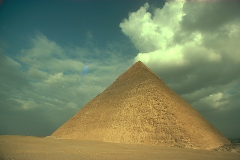

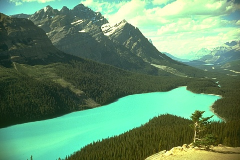

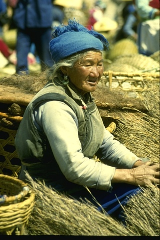

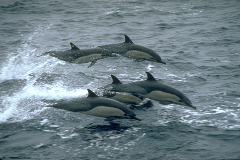

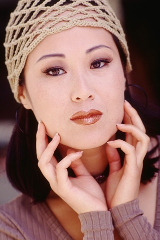

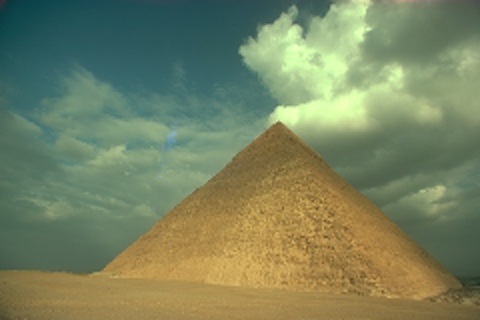

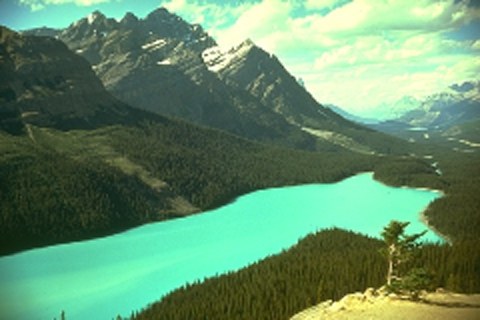

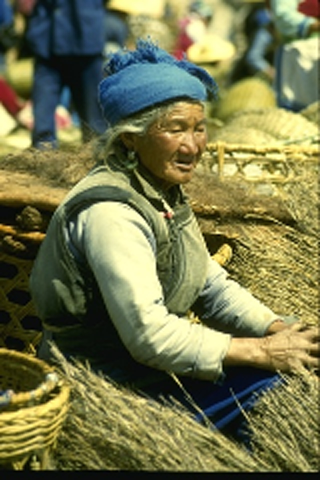

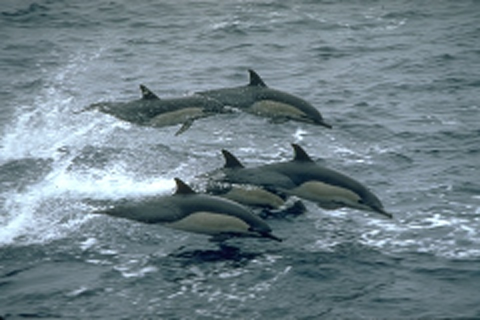

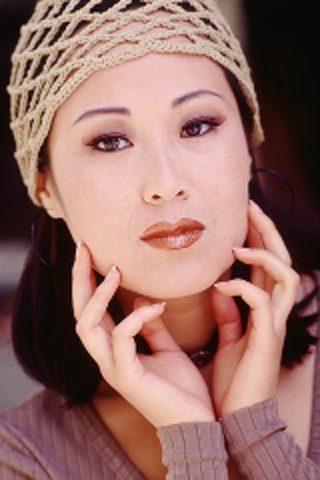

In [ ]:
for lr in lrImgs:
  lrRGB = convertYCrCbToRGB(lr)
  cv2_imshow(lrRGB)

for hr in hrImgs:
    hrRGB = convertYCrCbToRGB(hr)
    cv2_imshow(hrRGB)

Normalise the dataset

In [ ]:
train_ds_norm = (train_ds / 255.0)
val_ds_norm = (val_ds / 255.0)

print('Scale of the training samples:', (np.min(train_ds_norm), np.max(train_ds_norm)))
print('Scale of the training samples:', (np.min(val_ds_norm), np.max(val_ds_norm)))

Scale of the training samples: (0.0, 1.0)
Scale of the training samples: (0.0, 1.0)
